In [1]:
import pandas as pd
import numpy as np
import yaml
import sys
import jax

sys.path.append("../lib")
import utils
from nuance import Nuance

# Load data
params = yaml.full_load(open("../data/gp.yaml", "r"))
df = pd.read_csv("../data/lightcurves/P1.57774539_R0.51_1411.1671771309339.csv")

time, flux, error = df.values.T
t_0 = time[0]
time -= t_0

/Users/lgrcia/code/nuance/nuance/nuance.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from wotan import flatten
sys.path.append("../../synthetic_injection_recovery/lib")
from tls import tls

def search(time, flux, error, params, verbose=False):
    flatten_trend = trend(time, flux, params)
    flatten_flux = flux - flatten_trend
    flatten_flux -= np.mean(flatten_flux)
    flatten_flux += 1.

    model = tls(time, flatten_flux, verbose=verbose)
    periods = np.linspace(1, 1.8, 1000)
    results = model.power(periods, verbose=verbose, use_threads=1, show_progress_bar=verbose)
    
    return results["T0"], results["period"], periods, results["power"]

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

ImportError: numpy.core.multiarray failed to import

In [7]:
# Mask flares
# In what Fran Pozuelos sent me, the falres are sigma clipped. To remove their
# full extended signal, I locate and mask 30 points on each side of "holes" in
# time
window = 30
mask = np.pad(np.array(np.diff(time) < 3*np.median(np.diff(time))), (0, 1))
ups = np.flatnonzero(~mask)
if len(ups) > 0:
    mask[
        np.hstack(
            [
                np.arange(max(u - window, 0), min(u + window, len(nu.time)))
                for u in ups
            ]
        )
    ] = False

nu = Nuance(time[mask], flux[mask], error[mask], kernel=kernel, X=X[:, mask])

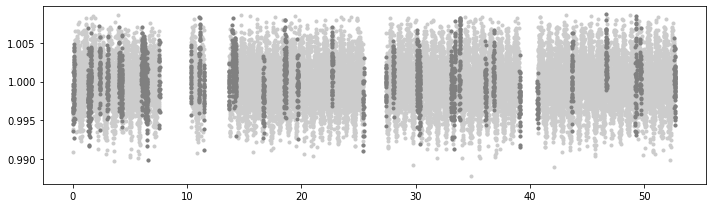

In [8]:
import matplotlib.pyplot as plt

plt.figure(None, (10, 3))
plt.plot(time, flux, ".", c="0.8")
plt.plot(time[~mask], flux[~mask], ".", c="0.5")
plt.tight_layout()

In [9]:
# linear search
t0s = time.copy()
Ds = np.linspace(0.01, 0.07, 6)
nu.linear_search(t0s, Ds)

# We mask directly the first planet signal
nu = nu.mask(0.9236153776066658, 0.02, 1.2390692712847524)

# Search of the second
periods = np.linspace(0.9, 10.1, 8000)
search = nu.periodic_search(periods)

100%|██████████████████████████████████████| 8000/8000 [00:21<00:00, 364.46it/s]


(-0.007243038640241527, 0.007243038640241527)

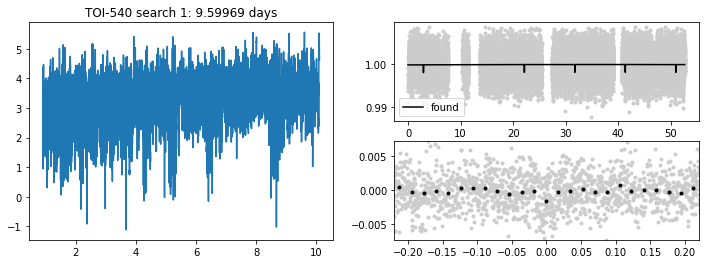

In [10]:
from nuance.utils import phase
import matplotlib.pyplot as plt

def binn(x, y, n):
    N = int(len(x)/n)
    ns = np.histogram(x, N)[0]
    bx = np.histogram(x, N, weights=x)[0]/ns
    by = np.histogram(x, N, weights=y)[0]/ns
    return bx, by

plt.figure(None, (12, 4))
t0, D, P = search.best

plt.subplot(2, 2, (1, 3))
plt.plot(search.periods, search.Q_snr)
plt.title(f"TOI-540 search 1: {P:.5f} days")

mean, astro, noise = nu.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(nu.time, nu.flux, ".", c="0.8")
plt.plot(nu.time, astro + mean, c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
mean, astro, noise = nu.models(t0, D, P)
phi = phase(nu.time, t0, P)
detrended = nu.flux - noise - mean
plt.plot(phi, detrended, ".", c=".8")
plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.xlim(*(np.array([-1, 1])*10*D))
plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4))

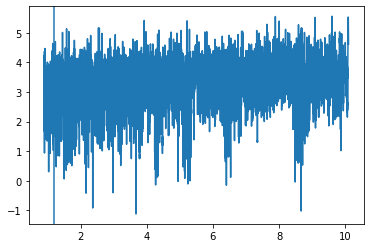

In [11]:
plt.plot(search.periods, search.Q_snr)
plt.axvline(1.19)

(2.5462441888736347, 3.0262441888736342)

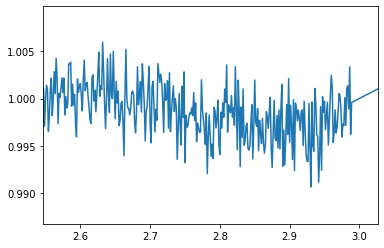

In [92]:
plt.plot(time[mask], flux[mask])
n = P
plt.xlim(t0 - 6*D + n, t0 + 6*D + n, ".")